In [1]:
import os
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from torchvision import transforms, utils
import torch
import numpy as np
import nibabel as nib
from random import randint
from PIL import Image
import torch.optim as optim
import time
import QuickNAT as QN
import torch.nn as nn
from livelossplot import PlotLosses

In [2]:
gpu_id = 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

device = torch.device('cuda')
print(device)

cuda


In [3]:
model = QN.QuickNAT(1,64,178)
model_params = list(model.parameters())
nb_param=0
for param in model.parameters():
    nb_param+=np.prod(list(param.data.size()))
print(nb_param)
model = model.to(device)

3303618


In [4]:
class TrainDataset(Dataset):
    """Training dataset with mask image mapping to classes"""
    def __init__(self, T1a_dir, parc1a_dir, transform=None):
        """
        Args:
            T1a_dir (string): Directory with T1w image in axial plane
            transform (callable): Optional transform to be applied on a sample
            parc1a_dir (string): Directory with parcellation scale 5 in axial plane
        """
        self._T1a_dir = T1a_dir
        self.transform = transform
        self._parc1a_dir = parc1a_dir
#         self.mapping = {
#             165: 91,
#             166: 164,
#         }
        
#     def mask_to_class(self, mask):
#         for k in self.mapping:
#             mask[mask==k] = self.mapping[k]
#         return mask
    
    def __len__(self):
        T1a_list = os.listdir(self._T1a_dir)
        return len(T1a_list)
    
    
    def __getitem__(self, idx):
        T1a_list = os.listdir(self._T1a_dir)
        parc1a_list = os.listdir(self._parc1a_dir)
        
        T1a_str = T1a_list[idx]
        
        T1a_arr = io.imread(os.path.join(self._T1a_dir, T1a_str))
        T1a_tensor = torch.from_numpy(T1a_arr)
        
        compose_T1 = transforms.Compose([transforms.ToPILImage(), 
                                         transforms.Resize((128,128),interpolation=Image.NEAREST),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        T1a_tensor = torch.unsqueeze(T1a_tensor, dim = 0)
        T1a_tensor = compose_T1(T1a_tensor)
              
        parc1a_str = parc1a_list[idx]
    
        parc1a_arr = io.imread(os.path.join(self._parc1a_dir, parc1a_str))
        parc1a_tensor = torch.from_numpy(parc1a_arr)
        
        compose = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((128,128),interpolation=Image.NEAREST), 
                                      transforms.ToTensor()])
        
        parc1a_tensor = torch.unsqueeze(parc1a_tensor, dim = 0)
        parc1a_tensor = compose(parc1a_tensor)
        parc1a_tensor = parc1a_tensor.squeeze()
        
        parc1a_tensor = torch.round(parc1a_tensor / 0.0039).byte()
#         parc1a_tensor = self.mask_to_class(parc1a_tensor)
      
        sample = {'T1a':T1a_tensor, 'parc1a':parc1a_tensor}
        
        if self.transform:
            T1a = self.transform(T1a_tensor)
            sample = {'T1a':T1a, 'parc1a':parc1a}
            
        return sample

In [5]:
sub_idx = 0
T1a_dir = '/home/xiaoyu/MRIdata/T1w/axial/sub{}'.format(sub_idx)
parc1a_dir = '/home/xiaoyu/MRIdata/parc_1/axial/sub{}'.format(sub_idx)
total_data = TrainDataset(T1a_dir=T1a_dir, parc1a_dir = parc1a_dir)
print(len(total_data))

182


In [6]:
for sub_idx in range(1,330):
    T1a_dir = '/home/xiaoyu/MRIdata/T1w/axial/sub{}'.format(sub_idx)
    parc1a_dir = '/home/xiaoyu/MRIdata/parc_1/axial/sub{}'.format(sub_idx)
    train_data = TrainDataset(T1a_dir=T1a_dir, parc1a_dir = parc1a_dir)
    total_data = total_data + train_data
print(len(total_data))
# total training images pairs is 3300.

60060


In [ ]:
colors = torch.tensor([])
for i in range(len(total_data)):
    sample = total_data[i]
    mask = sample['parc1a']
    unique_color = torch.unique(mask).float()
    colors = torch.cat((colors,unique_color))
colors = torch.unique(colors)
sorted_color, indices = torch.sort(colors)
print(sorted_color)
print(sorted_color.size())

In [6]:
# for sub_idx in range(1,330):

#     T1a_dir = '/home/xiaoyu/MRIdata/T1w/axial/sub{}'.format(sub_idx)
        
#     parc1a_dir = '/home/xiaoyu/MRIdata/parc_1/axial/sub{}'.format(sub_idx)
    
#     train_data = TrainDataset(T1a_dir=T1a_dir, parc1a_dir = parc1a_dir)
#     total_data += train_data
# print(len(total_data))

In [7]:
start=time.time()
dataloader = DataLoader(train_data, batch_size = 5, shuffle = True, num_workers = 4)
print(len(dataloader))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters() ,lr=0.001)

37


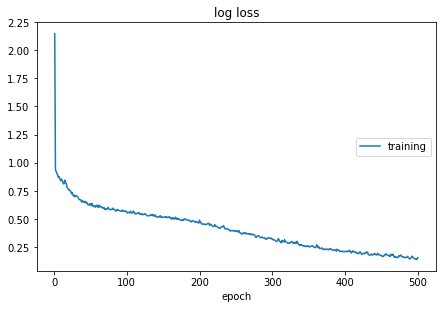

log loss:
training   (min:    0.141, max:    2.146, cur:    0.157)
Finish Training


In [8]:
liveloss = PlotLosses()
for epoch in range(0,500):
    logs = {}
    running_loss = 0
    num_batches = 0
    for i_batch, sample_batched in enumerate(dataloader):
    
        optimizer.zero_grad()
        
        #get the inputs
        inputs, labels = sample_batched['T1a'], sample_batched['parc1a']
        

        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs.requires_grad_()
        
        #forward + backward +optimize
        scores = model(inputs)

          
        # Define the loss
        loss = criterion(scores, labels.long()) 
        loss.backward()
        optimizer.step()
        
        # compute and accumulate stats
        running_loss += loss.detach().item()
       
        num_batches+=1 
        
        
    # AVERAGE STATS THEN DISPLAY    
    total_loss = running_loss/num_batches
   
    elapsed = (time.time()-start)/60
        
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t loss=', total_loss )
    logs['log loss'] = total_loss
            
    liveloss.update(logs)
    liveloss.draw()
   
print('Finish Training')
           